In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from conditioning_bias import OperatorRandomForestClassifier, OperatorDecisionTreeClassifier

from smote_variants.oversampling import SMOTE

import common_datasets.binary_classification as binclas

In [2]:
import matplotlib.pyplot as plt

In [3]:
dataset = binclas.load_haberman()
X = dataset['data']
y = dataset['target']

In [4]:
X = StandardScaler().fit_transform(X)

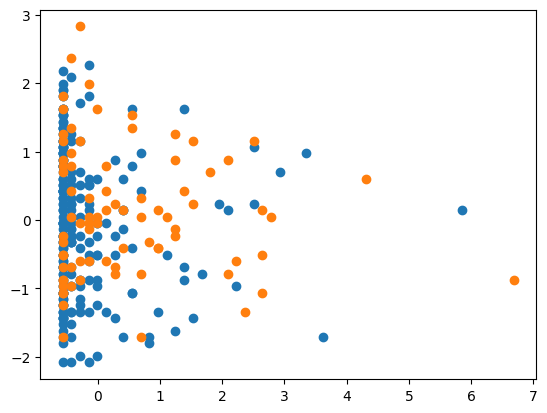

In [5]:
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [6]:
from sklearn.neighbors import NearestNeighbors

In [7]:
X_min = X[y == 1]
X_min = StandardScaler().fit_transform(X_min)
indices = NearestNeighbors(n_neighbors=5).fit(X_min).kneighbors(X_min, return_distance=False)

In [8]:
def joint_neighborhood_ratios(X, y):

    X_min = X[y == 1]
    X_min = StandardScaler().fit_transform(X_min)
    indices = NearestNeighbors(n_neighbors=5).fit(X_min).kneighbors(X_min, return_distance=False)
    count = 0
    count_none = 0
    for idx, inds in enumerate(indices):
        flag = False
        for ind in inds[1:]:
            if idx in indices[ind]:
                count += 1
                flag = True
        if not flag:
            count_none += 1
    return count/len(X_min), count_none/len(X_min)

In [9]:
def comparison(X, y):
    X = StandardScaler().fit_transform(X)
    X_min = X[y == 1]
    X_maj = X[y == 0]

    indices = NearestNeighbors(n_neighbors=5).fit(X_min).kneighbors(X_min, return_distance=False)
    all_points = (X_min[:, None] + X_min[indices[:, 1:]]) / 2
    all_points = all_points.reshape((all_points.shape[0]*all_points.shape[1], all_points.shape[2]))

    indices = NearestNeighbors(n_neighbors=5).fit(X).kneighbors(all_points, return_distance=False)
    return np.bincount(y[indices.ravel()])


In [10]:
comparison(X[:, :], y)

array([776, 844])

In [11]:
import logging
logger = logging.getLogger('smote_variants')
logger.setLevel(logging.ERROR)

In [12]:
class RandomForestClassifierImproved:
    def __init__(self, smote, min_samples_leaf=5, random_state=None, bootstrap=True, n_estimators=200):
        self.smote = smote
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    def fit(self, X, y, sample_weight=None):
        self.estimators = []
        self.masks = []
        for idx in range(1000):
            estimator = OperatorDecisionTreeClassifier(max_features='sqrt', min_weight_fraction_leaf=2/len(X), mode='avg')
            bootstrap = np.random.randint(0, X.shape[0], X.shape[0])
            X_train = X[bootstrap]
            y_train = y[bootstrap]

            """X0 = X_train[y_train == 0]
            X1 = np.unique(X_train[y_train == 1], axis=0)
            #X1 = X[y == 1]

            #bootstrap = np.random.choice(np.arange(X1.shape[0]), X1.shape[0], replace=True)
            #X1 = X1[bootstrap]

            X_train = np.vstack([X0, X1])
            y_train = np.hstack([np.repeat(0, X0.shape[0]), np.repeat(1, X1.shape[0])])"""

            smote = SMOTE(
                random_state=5,
                n_neighbors=1,
                #proportion=2.0,
                #proportion=1.0 + (np.random.random_sample()-1)*0.5,
                ss_params={'gaussian_component': {'sigma': 0.0, 'fraction': 1.0}, 'n_dim': 2},
                nn_params={'metric_learning_method': 'n_unique_inv', 'metric': 'precomputed', 'random_state': 5}
            )
            #X_train = X_train + np.random.random_sample(X_train.shape)

            X_train, y_train = smote.sample(X_train, y_train)
            """X0 = X_train[y_train == 0]
            X1 = X_train[y_train == 1]
            X_train = np.vstack([X0, X1, X1])
            y_train = np.hstack([np.repeat(0, X0.shape[0]), np.repeat(1, X1.shape[0]*2)])"""
            sample_weight = np.hstack([np.repeat(1.0, X.shape[0]), np.repeat(0.5, X_train.shape[0] - X.shape[0])])
            estimator.fit(X_train, y_train, sample_weight=sample_weight)
            self.estimators.append(estimator)
        return self

    def predict_proba(self, X):
        return np.mean([estimator.predict_proba(X) for estimator in self.estimators], axis=0)

In [13]:
dataset = binclas.load_yeast_1_vs_7()
dataset = binclas.load_saheart()
dataset = binclas.load_haberman()
X = dataset['data']
y = dataset['target']

print(len(X), len(np.unique(X, axis=0)))
print(X[:3])
print([len(np.unique(X[:, idx])) for idx in range(X.shape[1])])
print(X[y == 1][:5])
print(np.bincount(y))
print(joint_neighborhood_ratios(X, y))
print(comparison(X, y))

validator = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=5)

res0 = []
res1 = []
res2 = []
res3 = []
res4 = []

#X = X + np.random.random_sample(size=X.shape) * 0.001

for idx, (train, test) in enumerate(validator.split(X, y, y)):

    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]



    """pca = PCA(n_components=X_train.shape[1]).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)"""

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    X1_mean = np.mean(X_train[y_train == 1], axis=0)
    dists = np.sum((X_train[y_train==1] - X1_mean)**2, axis=1)
    mask = dists < np.sort(dists)[-5]
    X0 = X_train[y_train == 0]
    X1 = X_train[y_train == 1][mask]
    X_train = np.vstack([X0, X1])
    y_train = np.hstack([np.repeat(0, X0.shape[0]), np.repeat(1, X1.shape[0])])

    smote0 = SMOTE(random_state=5)
    smote1 = SMOTE(
        random_state=5,
        n_neighbors=5,
        #proportion=2.0,
        ss_params={'gaussian_component': {'sigma': 0.0, 'fraction': 1.0}, 'n_dim': 2},
        #nn_params={'metric_learning_method': 'MI_weighted', 'metric': 'precomputed', 'random_state': 5}
    )
    smote2 = SMOTE(
        random_state=5,
        #n_neighbors=1,
        #proportion=2.0,
        ss_params={'gaussian_component': {'sigma': 0.01, 'fraction': 1.0}, 'n_dim': 2},
        #nn_params={'metric_learning_method': 'id', 'metric': 'precomputed', 'random_state': 5}
    )
    smote3 = SMOTE(
        random_state=5,
        #n_neighbors=1,
        #proportion=2.0,
        ss_params={'gaussian_component': {'sigma': 0.0, 'fraction': 1.0}, 'n_dim': 2},
        #nn_params={'metric_learning_method': 'n_unique_inv', 'metric': 'precomputed', 'random_state': 5}
    )

    X_samp0, y_samp0 = smote0.sample(X_train, y_train)
    X_samp1, y_samp1 = smote1.sample(X_train, y_train)
    X_samp2, y_samp2 = smote2.sample(X_train, y_train)
    X_samp3, y_samp3 = smote3.sample(X_train, y_train)

    sample_weight=np.hstack([np.repeat(1.0, X_train.shape[0]), np.repeat(0.5, X_samp1.shape[0] - X_train.shape[0])])

    msl = 13

    rf_params = {'min_samples_leaf': 13, 'random_state': 5, 'bootstrap': True, 'n_estimators': 1000}
    rfs_params = {'min_samples_leaf': msl, 'random_state': 6, 'bootstrap': True, 'n_estimators': 1000}

    classifier = OperatorRandomForestClassifier(**(rfs_params | {'bootstrap': True, 'min_weight_fraction_leaf': 2.0/len(X_samp0)}), mode='avg_half')
    classifier.fit(X_samp0, y_samp0)
    pred = classifier.predict_proba(X_test)[:, 1]
    res0.append(roc_auc_score(y_test, pred))

    classifier = RandomForestClassifierImproved(**(rfs_params | {'min_samples_leaf': msl}), smote=smote3)
    classifier.fit(X_train, y_train)
    pred = classifier.predict_proba(X_test)[:, 1]
    res1.append(roc_auc_score(y_test, pred))

    classifier = OperatorRandomForestClassifier(**rfs_params, mode='avg_half')
    classifier.fit(X_samp2, y_samp2)
    pred = classifier.predict_proba(X_test)[:, 1]
    res2.append(roc_auc_score(y_test, pred))

    """classifier = RandomForestClassifier(**rfs_params)
    classifier.fit(X_samp3, y_samp3, sample_weight=sample_weight)
    pred = classifier.predict_proba(X_test)[:, 1]
    res3.append(roc_auc_score(y_test, pred))"""


    classifier = OperatorRandomForestClassifier(**rfs_params#, class_weight={0: 1.0, 1: np.sum(1 - y_train)/np.sum(y_train)}
                                        ,mode='avg_half')
    classifier.fit(X_train, y_train)
    pred = classifier.predict_proba(X_test)[:, 1]
    res3.append(roc_auc_score(y_test, pred))


    classifier = OperatorRandomForestClassifier(**(rf_params | {'bootstrap': True}), mode='avg_half')
    classifier.fit(X_train, y_train)
    pred = classifier.predict_proba(X_test)[:, 1]
    res4.append(roc_auc_score(y_test, pred))

    if idx % 10 == 0:
        print(np.mean(res0), np.mean(res1), np.mean(res2), np.mean(res3), np.mean(res4))
    #break


306 283
[[ 2. 38. 59.]
 [ 4. 39. 63.]
 [ 1. 49. 62.]]
[31, 49, 12]
[[ 0. 45. 66.]
 [ 1. 63. 60.]
 [ 8. 69. 67.]
 [ 5. 61. 62.]
 [ 4. 53. 58.]]
[225  81]
(2.8395061728395063, 0.09876543209876543)
[772 848]


0.603921568627451 0.6261437908496732 0.5986928104575164 0.6366013071895424 0.6431372549019607
0.7048499702911467 0.6802473262032085 0.7060606060606062 0.6983437314319668 0.6980912061794414
0.7140153283535637 0.6938920012449424 0.7196992685963274 0.714513305322129 0.7132878151260504
0.7095601412608056 0.6882827324478178 0.7127358739194604 0.7096787370862323 0.7104298439806029
0.7152807667782561 0.6921907380838515 0.718140243902439 0.7166596923322175 0.7168121313566077
0.7145577021658337 0.6937107522747661 0.7161163975394079 0.7154820261437908 0.7155180699730873
0.7156635058394943 0.6917838583520841 0.7169358727097397 0.7166552823315118 0.7171568627450982
0.7167403111479335 0.6933558869557213 0.7181556660222777 0.7167011875172605 0.7172713568995674
0.7176147825385298 0.6952004155571694 0.7183490680222706 0.718486242233519 0.7190576333414024
0.7159538174244058 0.6963720103425987 0.7170500251382607 0.7179047259929612 0.7188595309918838
0.7169400763605773 0.6975158545266289 0.71861693522293

KeyboardInterrupt: 

In [ ]:
np.mean(res0), np.mean(res1), np.mean(res2), np.mean(res3), np.mean(res4)

(0.9252715517241379,
 0.9300951794510908,
 0.9287995249824067,
 0.9308575826882477,
 0.9308951442646023)

In [ ]:
np.median(res0), np.median(res1), np.median(res2), np.median(res3), np.median(res4)

(0.9285714285714286,
 0.935960591133005,
 0.9334975369458128,
 0.93481703026038,
 0.9359605911330049)